# **Análisis exploratorio de datos**

## ***Librerias***

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from collections import Counter
import itertools


from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
import nltk


In [3]:
stemmer = PorterStemmer()
#nltk.download('punkt')

## **Carga y análisis de datos**

In [36]:
df = pd.read_csv('data/raw/dataset.tsv', sep='\t',  names=['label', 'message'], header=None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    11000 non-null  object
 1   message  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


El conjunto de datos cuenta con un total de ``2 columnas`` y ``11000 filas``, no se tienen valores perdidos.

In [6]:
df.head(7)

,label,message
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...
1,neg,"adha drama to censor hi hojaye gaa , khaas to..."
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...
3,neg,choor kasuri choor jhootay ka moo kaala
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...
5,neg,hum kia aur hamari logic kia bhonkoon k muted...
6,neg,imran khan altaf hussain chachoo haroon ab sa...


In [7]:
df['label'].unique()
indices = df[df['label'] == ' '].index
df = df.drop(indices)
data=df.copy()

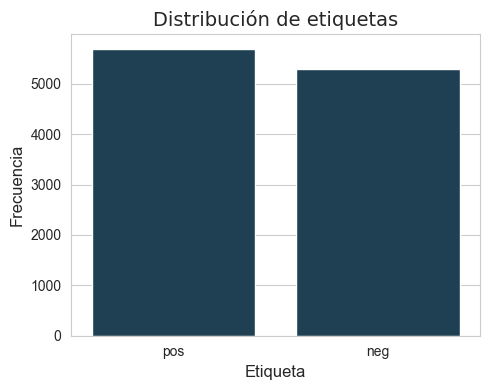

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 4))
sns.barplot(
    x=df['label'].value_counts().index,
    y=df['label'].value_counts().values,
    color='#16425b'
)
plt.title("Distribución de etiquetas", fontsize=14, fontname='DejaVu Sans')
plt.xlabel("Etiqueta", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.tight_layout()
plt.show()


Como conclusión dle gráfico anterior, se puede observar que no hay gran desbalance entre las etiquetas de los mensages presentes en el dataset de interés. Veamos luego los análisis pertinentes para cada uno de los mensages a los cuales se buscará clasificar mas adelante.

In [9]:
df['Length'] = df['message'].str.len()
df.head(7)

,label,message,Length
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...,116
1,neg,"adha drama to censor hi hojaye gaa , khaas to...",471
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...,223
3,neg,choor kasuri choor jhootay ka moo kaala,40
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...,51
5,neg,hum kia aur hamari logic kia bhonkoon k muted...,179
6,neg,imran khan altaf hussain chachoo haroon ab sa...,247


In [10]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word_count'] = df['message'].apply(word_count)
df.head(7)

,label,message,Length,Word_count
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...,116,22
1,neg,"adha drama to censor hi hojaye gaa , khaas to...",471,93
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...,223,45
3,neg,choor kasuri choor jhootay ka moo kaala,40,7
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...,51,9
5,neg,hum kia aur hamari logic kia bhonkoon k muted...,179,35
6,neg,imran khan altaf hussain chachoo haroon ab sa...,247,51


In [11]:
df['mean_word_length'] = df['message'].map(lambda rev: np.mean([len(word) for word in rev.split()]).round(3))
df.head(7)

,label,message,Length,Word_count,mean_word_length
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...,116,22,4.273
1,neg,"adha drama to censor hi hojaye gaa , khaas to...",471,93,4.054
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...,223,45,3.933
3,neg,choor kasuri choor jhootay ka moo kaala,40,7,4.714
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...,51,9,4.556
5,neg,hum kia aur hamari logic kia bhonkoon k muted...,179,35,4.114
6,neg,imran khan altaf hussain chachoo haroon ab sa...,247,51,3.843


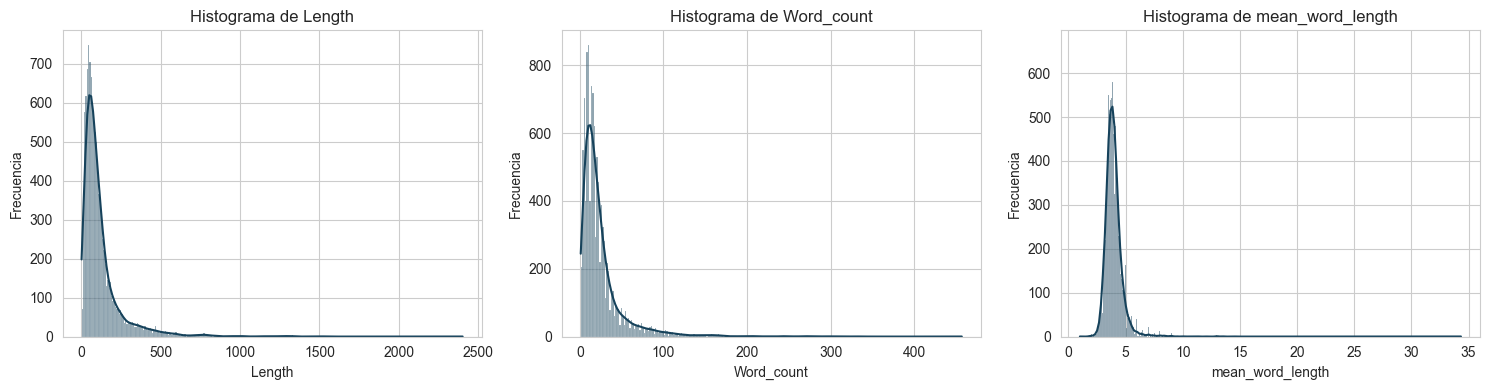

In [12]:
sns.set_style("whitegrid")
columnas = ['Length', 'Word_count', 'mean_word_length']  # reemplaza con los nombres reales
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Crear los histogramas
for i, col in enumerate(columnas):
    sns.histplot(df[col], ax=axes[i], kde=True, color='#16425b')
    axes[i].set_title(f'Histograma de {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ajustar espacios
plt.tight_layout()
plt.show()


Los tres histogramas muestran que la mayoría de los textos son cortos: tienen menos de 500 caracteres y menos de 100 palabras. Además, las palabras que usan suelen ser breves, de unas 4 a 6 letras en promedio. Aunque hay algunos textos muy largos o con palabras inusualmente largas, son pocos y no representan la mayoría.

### ***Limpieza de palabras de relleno***

Parte del código de algunas funciones utilizadas durante el desarrollo de este trabajo provienen del proyecto ``Roman Urdu Sentimental Analysis``, disponible en: [[enlace](https://www.kaggle.com/code/itsnobita/roman-urdu-sentimental-analysis)].

In [13]:
def load_stopwords_from_csv(csv_file):
    stopwords = set()
    with open(csv_file, newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            stopwords.add(row[0])
    return stopwords

In [14]:
def corpus(text):
    text_list = text.split()
    return text_list

En mismo proyecto mencionado anteriormente se disponia de un dataset que contenia la mayoria de las stopwords relacionadas al lenguaje Urdun, este dataset será usado para la limpieza de los mensajes en el conjunto de datos.

In [15]:
stopwords_csv_file = 'data/raw/RomanUrdu_stopwords.csv'
urdu_stopwords = load_stopwords_from_csv(stopwords_csv_file)

In [ ]:
tokenizer = TreebankWordTokenizer()

def clean_text(urdu_text):
    urdu_text = urdu_text.lower()
    tokens = tokenizer.tokenize(urdu_text)  # Usa tokenizer sin dependencias de 'punkt'
    tokens = [t for t in tokens if len(t) > 1]
    tokens = [stemmer.stem(word) for word in tokens if word not in urdu_stopwords]
    return ' '.join(tokens)


In [17]:
print("="*40)
print("Mensaje original:")
print(data["message"][0])
print("\nMensaje limpio:")
print(clean_text(data["message"][0]))
print("="*40)

Mensaje original:
 ab achanak khawaja saad rafique ko khiyaal aagaya woh bhe peshawar mai is line pai 10 saal sai koi train nahe guzri

Mensaje limpio:
achanak khawaja saad rafiqu khiyaal aagaya woh bhe peshawar line pai 10 saal train nahe guzri


Ahora se aplicará la funcion de limpieza a todo el dataset para seguir con los análisis y preprosesamientos necesarios.

In [18]:
data['clean_text'] = data['message'].apply(clean_text)

In [20]:
data['message_lists'] = data['clean_text'].apply(corpus)
data.head(10)

,label,message,clean_text,message_lists
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...,achanak khawaja saad rafiqu khiyaal aagaya woh...,"[achanak, khawaja, saad, rafiqu, khiyaal, aaga..."
1,neg,"adha drama to censor hi hojaye gaa , khaas to...",adha drama to censor hi hojay gaa khaa tor bas...,"[adha, drama, to, censor, hi, hojay, gaa, khaa..."
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...,bekaar fuzool end moti budhi laila jeet gaye l...,"[bekaar, fuzool, end, moti, budhi, laila, jeet..."
3,neg,choor kasuri choor jhootay ka moo kaala,choor kasuri choor jhootay moo kaala,"[choor, kasuri, choor, jhootay, moo, kaala]"
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...,gali gali mein shor gaaanjaaaa shair chor,"[gali, gali, mein, shor, gaaanjaaaa, shair, chor]"
5,neg,hum kia aur hamari logic kia bhonkoon k muted...,hum kia hamari logic kia bhonkoon mute bhonk a...,"[hum, kia, hamari, logic, kia, bhonkoon, mute,..."
6,neg,imran khan altaf hussain chachoo haroon ab sa...,imran khan altaf hussain chachoo haroon sadmey...,"[imran, khan, altaf, hussain, chachoo, haroon,..."
7,neg,lagta ha sab bhonkay hath xaray kar rahay hei...,lagta sab bhonkay hath xaray kar rahay panama ...,"[lagta, sab, bhonkay, hath, xaray, kar, rahay,..."
8,neg,merey bahi tum saye kaha rahey hoo but main t...,merey bahi tum say kaha rahey hoo main tum ak ...,"[merey, bahi, tum, say, kaha, rahey, hoo, main..."
9,neg,nawaz khanzaaney ka moun khul chukaa hai sab ...,nawaz khanzaaney moun khul chukaa sab kha rahi...,"[nawaz, khanzaaney, moun, khul, chukaa, sab, k..."


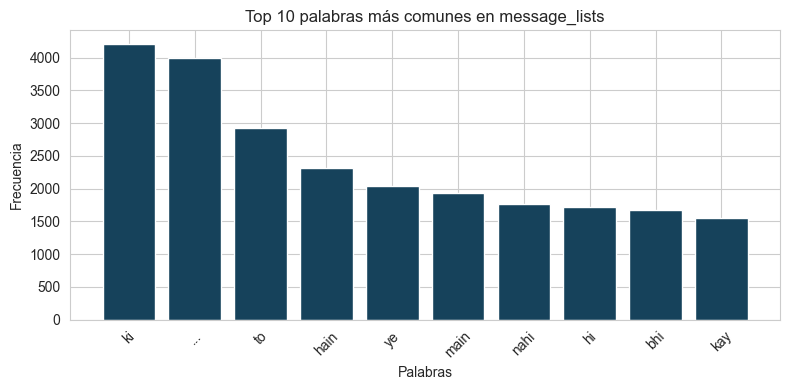

In [32]:
all_words = list(itertools.chain.from_iterable(data['message_lists']))
word_counts = Counter(all_words)
top_10 = word_counts.most_common(10)
words, counts = zip(*top_10)

# Graficar
plt.figure(figsize=(8, 4))
plt.bar(words, counts, color='#16425b')
plt.title('Top 10 palabras más comunes en message_lists')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [34]:
data=data[['label','clean_text']]
data.to_csv('data/processed/to_model.csv', index=False)